# Tutorial 3: JIT Connection Matrices - Just-In-Time Generated Random Connections

In ultra-large-scale neural network modeling, even using sparse matrices, storing all connection weights still requires a large amount of memory. **JIT Connection Matrices** (Just-In-Time Connectivity) provide a revolutionary solution: **instead of pre-storing weight matrices, connections are generated just-in-time during computation**.

This tutorial will introduce three JIT connection structures provided by BrainEvent: **JITCHomoR**, **JITCNormalR**, and **JITCUniformR**.

## Contents
1. Core concepts of JIT connections
2. JITCHomoR - Homogeneous weights
3. JITCNormalR - Normal distribution weights
4. JITCUniformR - Uniform distribution weights
5. Memory and performance comparison
6. Practice: Ultra-large-scale network modeling
7. Advanced techniques: Row-oriented vs Column-oriented

## 1. Core concepts of JIT connections

### Problems with traditional methods

Consider a network with 1 million neurons, where each neuron connects to 1000 other neurons:
- **Total connections**: 1,000,000 × 1,000 = 1 billion
- **Memory requirement**: 1 billion × 4 bytes (float32) ≈ **4 GB**

Even using sparse matrices (CSR), we still need to store 1 billion weight values!

### JIT connection solution

**Core idea**: Don't store weights, only store generation rules!

- **Stored content**: Connection probability, weight distribution parameters, random seed
- **Memory requirement**: A few scalars ≈ **a few dozen bytes**!
- **During computation**: Dynamically generate needed connections based on random seed

### Key advantages
- ✅ **Extremely low memory**: Only stores distribution parameters
- ✅ **Reproducible**: Fixed seed ensures consistent results
- ✅ **Efficient computation**: Only generates needed connections
- ✅ **Scalable**: Supports ultra-large-scale networks

In [2]:
import brainevent
import brainstate
import jax.numpy as jnp
import jax
import numpy as np

print(f"BrainEvent version: {brainevent.__version__}")


BrainEvent version: 0.0.4


## 2. JITCHomoR - Homogeneous weight connections

**JITCHomoR** (Homogeneous Row-oriented) represents a sparse connection matrix where all connections have the **same weight value**.

### Use cases
- Uniform excitatory connections
- Uniform inhibitory connections
- Binary neural networks

### Creation method

In [4]:
# Create a JIT connection matrix with homogeneous weights
# Parameters: (weight, connection probability, random seed)

n_pre = 1000   # Number of presynaptic neurons
n_post = 500   # Number of postsynaptic neurons

# All connection weights are 0.1, connection probability 10%
jitc_homo = brainevent.JITCScalarR(
    data=(0.1, 0.1, 12345),  # (weight, prob, seed)
    shape=(n_pre, n_post)
)

print("JITCScalarR matrix information:")
print(f"  shape: {jitc_homo.shape}")
print(f"  weight: {jitc_homo.weight}")
print(f"  connection probability: {jitc_homo.prob}")
print(f"  random seed: {jitc_homo.seed}")
print(f"\nMemory usage: Only stores 3 parameters!")

JITCHomoR matrix information:
  shape: (1000, 500)
  weight: 0.10000000149011612
  connection probability: 0.1
  random seed: 12345

Memory usage: Only stores 3 parameters!


### Using with BinaryArray

In [5]:
# Generate input spikes
brainstate.random.seed(0)
spikes_bool = brainstate.random.bernoulli(0.05, size=(n_pre,))
spikes = brainevent.BinaryArray(spikes_bool)

print(f"Input spikes: {spikes.sum()} / {n_pre} neurons fired")

# Event-driven matrix multiplication
# JIT connection will generate corresponding connections just-in-time based on firing neurons
output = spikes @ jitc_homo

print(f"\nOutput:")
print(f"  shape: {output.shape}")
print(f"  maximum value: {output.max():.4f}")
print(f"  average value: {output.mean():.4f}")
print(f"  non-zero outputs: {jnp.sum(output > 0)} neurons")

Input spikes: 65 / 1000 neurons fired

Output:
  shape: (500,)
  maximum value: 1.5000
  average value: 0.6384
  non-zero outputs: 499 neurons


### Reproducibility test

In [6]:
# Create two matrices with the same seed
jitc1 = brainevent.JITCScalarR((0.1, 0.1, 999), shape=(100, 50))
jitc2 = brainevent.JITCScalarR((0.1, 0.1, 999), shape=(100, 50))

# Use the same input
test_input = brainevent.BinaryArray(jnp.ones(100, dtype=bool))

result1 = test_input @ jitc1
result2 = test_input @ jitc2

print("Reproducibility test:")
print(f"  Result1 and Result2 are identical: {jnp.allclose(result1, result2)}")
print(f"  Maximum difference: {jnp.abs(result1 - result2).max()}")

# Different seeds produce different connections
jitc3 = brainevent.JITCScalarR((0.1, 0.1, 888), shape=(100, 50))
result3 = test_input @ jitc3

print(f"\nDifferent seeds produce different results:")
print(f"  Result1 and Result3 are identical: {jnp.allclose(result1, result3)}")
print(f"  Average difference: {jnp.abs(result1 - result3).mean():.4f}")

Reproducibility test:
  Result1 and Result2 are identical: True
  Maximum difference: 0.0

Different seeds produce different results:
  Result1 and Result3 are identical: False
  Average difference: 0.1940


## 3. JITCNormalR - Normal distribution weights

**JITCNormalR** connection weights follow a **normal distribution** N(μ, σ²), which better matches the reality of biological neural networks.

### Use cases
- Biologically realistic synapse weight distributions
- Networks requiring weight variability
- Random network initialization

In [7]:
# Create JIT connection with normally distributed weights
# Parameters: (mean, standard deviation, connection probability, random seed)

jitc_normal = brainevent.JITCNormalR(
    data=(0.0, 0.1, 0.15, 42),  # (mean, std, prob, seed)
    shape=(1000, 500)
)

print("JITCNormalR matrix information:")
print(f"  shape: {jitc_normal.shape}")
print(f"  weight mean: {jitc_normal.wloc}")
print(f"  weight standard deviation: {jitc_normal.wscale}")
print(f"  connection probability: {jitc_normal.prob}")
print(f"  random seed: {jitc_normal.seed}")

JITCNormalR matrix information:
  shape: (1000, 500)
  weight mean: 0.0
  weight standard deviation: 0.10000000149011612
  connection probability: 0.15
  random seed: 42


### Visualizing weight distribution

Sampling statistics:
  Number of samples: 100
  Samples collected: 46436
  Mean: -0.0018
  Standard deviation: 0.1727


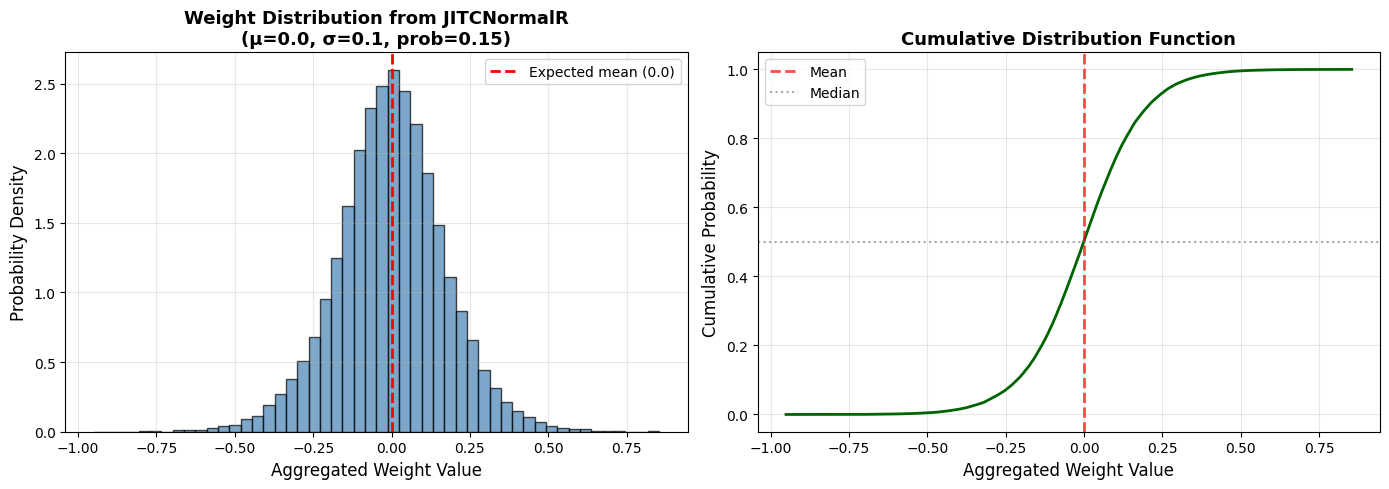


Explanation:
  - Left plot shows the probability density distribution of weights
  - Right plot shows the cumulative distribution function (CDF)
  - Due to sparse connections, single outputs are sums of multiple weights


In [8]:
# Sample and visualize weight distribution

# Sample weights: Use sparse input for multiple samples
n_samples_iter = 100
weights_samples = []

brainstate.random.seed(42)
for i in range(n_samples_iter):
    # Use different random sparse input each time
    random_spikes = brainevent.BinaryArray(brainstate.random.bernoulli(0.02, size=(1000,)))
    out = random_spikes @ jitc_normal
    # Collect non-zero outputs (these are weighted sums that reflect weight distribution)
    weights_samples.extend(out[out != 0].tolist())

print(f"Sampling statistics:")
print(f"  Number of samples: {n_samples_iter}")
print(f"  Samples collected: {len(weights_samples)}")
print(f"  Mean: {np.mean(weights_samples):.4f}")
print(f"  Standard deviation: {np.std(weights_samples):.4f}")

# Use matplotlib to plot histogram (braintools is better suited for spike rasters)
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: Weight distribution histogram
axes[0].hist(weights_samples, bins=50, density=True, alpha=0.7, edgecolor='black', color='steelblue')
axes[0].axvline(0.0, color='red', linestyle='--', linewidth=2, label='Expected mean (0.0)')
axes[0].set_xlabel('Aggregated Weight Value', fontsize=12)
axes[0].set_ylabel('Probability Density', fontsize=12)
axes[0].set_title('Weight Distribution from JITCNormalR\n(μ=0.0, σ=0.1, prob=0.15)', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Right plot: Cumulative distribution
sorted_weights = np.sort(weights_samples)
cumulative = np.arange(1, len(sorted_weights) + 1) / len(sorted_weights)
axes[1].plot(sorted_weights, cumulative, linewidth=2, color='darkgreen')
axes[1].axvline(0.0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Mean')
axes[1].axhline(0.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.7, label='Median')
axes[1].set_xlabel('Aggregated Weight Value', fontsize=12)
axes[1].set_ylabel('Cumulative Probability', fontsize=12)
axes[1].set_title('Cumulative Distribution Function', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nExplanation:")
print(f"  - Left plot shows the probability density distribution of weights")
print(f"  - Right plot shows the cumulative distribution function (CDF)")
print(f"  - Due to sparse connections, single outputs are sums of multiple weights")

## 4. JITCUniformR - Uniform distribution weights

**JITCUniformR** connection weights are **uniformly distributed** within a specified interval U(a, b).

### Use cases
- Networks requiring bounded weights
- Avoiding extreme weight values
- Controlling weight range during initialization

In [9]:
# Create JIT connection with uniformly distributed weights
# Parameters: (minimum value, maximum value, connection probability, random seed)

jitc_uniform = brainevent.JITCUniformR(
    data=(-0.1, 0.3, 0.12, 777),  # (wmin, wmax, prob, seed)
    shape=(800, 400)
)

print("JITCUniformR matrix information:")
print(f"  shape: {jitc_uniform.shape}")
print(f"  weight minimum value: {jitc_uniform.wlow}")
print(f"  weight maximum value: {jitc_uniform.whigh}")
print(f"  connection probability: {jitc_uniform.prob}")
print(f"  random seed: {jitc_uniform.seed}")
print(f"\nExpected weight mean: {(jitc_uniform.wlow + jitc_uniform.whigh) / 2:.4f}")

JITCUniformR matrix information:
  shape: (800, 400)
  weight minimum value: -0.10000000149011612
  weight maximum value: 0.30000001192092896
  connection probability: 0.12
  random seed: 777

Expected weight mean: 0.1000


In [10]:
# Test uniform distribution
test_spikes = brainevent.BinaryArray(jnp.ones(800, dtype=bool))
output = test_spikes @ jitc_uniform

print(f"Output statistics:")
print(f"  minimum value: {output.min():.4f}")
print(f"  maximum value: {output.max():.4f}")
print(f"  average value: {output.mean():.4f}")
print(f"  non-zero outputs: {jnp.sum(output != 0)}")

Output statistics:
  minimum value: 6.3203
  maximum value: 13.5678
  average value: 9.4209
  non-zero outputs: 400


## 5. Memory and performance comparison

Let's compare the memory usage and performance of JIT connections with traditional sparse matrices.

## 6. Practice: Ultra-large-scale spiking neural network

Build a million-neuron network using JIT connections.

In [11]:
class MassiveJITCNetwork:
    """Ultra-large-scale spiking neural network using JIT connections"""
    
    def __init__(self, n_input, n_hidden, n_output, 
                 conn_prob=0.01, seed=0):
        """
        Args:
            n_input: number of input layer neurons (can be very large!)
            n_hidden: number of hidden layer neurons
            n_output: number of output layer neurons
            conn_prob: connection probability
            seed: random seed
        """
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.n_output = n_output
        
        # Using JIT connections, memory usage is extremely low regardless of network size!
        self.w1 = brainevent.JITCNormalR(
            (0.0, 0.05, conn_prob, seed),
            shape=(n_input, n_hidden)
        )
        
        self.w2 = brainevent.JITCNormalR(
            (0.0, 0.1, conn_prob * 2, seed + 1),
            shape=(n_hidden, n_output)
        )
        
        # Estimate memory required if using CSR
        csr_memory = (n_input * n_hidden * conn_prob * 4 +  # w1
                      n_hidden * n_output * conn_prob * 2 * 4)  # w2
        
        print(f"Network structure: {n_input:,} -> {n_hidden:,} -> {n_output:,}")
        print(f"Connection probability: {conn_prob*100}%")
        print(f"\nTheoretical connection count:")
        print(f"  First layer: {int(n_input * n_hidden * conn_prob):,}")
        print(f"  Second layer: {int(n_hidden * n_output * conn_prob * 2):,}")
        print(f"\nMemory comparison:")
        print(f"  JITC method: < 1 KB")
        print(f"  CSR method:  {csr_memory / 1024 / 1024:.1f} MB")
        print(f"  Savings:     {csr_memory / 1024:.0f}x\n")
    
    def forward(self, input_spikes):
        """Forward propagation"""
        # First layer
        hidden_input = input_spikes @ self.w1
        hidden_spikes = brainevent.BinaryArray(hidden_input > 0.2)
        
        # Second layer
        output_input = hidden_spikes @ self.w2
        
        return output_input, hidden_spikes

# Create a large network (try even larger scales if memory permits!)
large_network = MassiveJITCNetwork(
    n_input=100000,   # 100K input neurons
    n_hidden=50000,   # 50K hidden neurons
    n_output=1000,    # 1K output neurons
    conn_prob=0.01,   # 1% connections
    seed=2024
)

Network structure: 100,000 -> 50,000 -> 1,000
Connection probability: 1.0%

Theoretical connection count:
  First layer: 50,000,000
  Second layer: 1,000,000

Memory comparison:
  JITC method: < 1 KB
  CSR method:  194.5 MB
  Savings:     199219x



In [12]:
# Test large network
print("Testing ultra-large-scale network...\n")

# Generate input spikes (sparse)
brainstate.random.seed(999)
input_pattern = brainstate.random.bernoulli(0.001, size=(100000,))  # 0.1% firing rate
input_spikes = brainevent.BinaryArray(input_pattern)

print(f"Input spikes: {input_spikes.sum()} / 100,000 ({input_spikes.sum()/100000*100:.2f}%)")

# Forward propagation
import time
start = time.time()
output, hidden_spikes = large_network.forward(input_spikes)
output = jax.block_until_ready(output)
compute_time = time.time() - start

print(f"\nHidden layer spikes: {hidden_spikes.sum()} / 50,000 ({hidden_spikes.sum()/50000*100:.2f}%)")
print(f"\nOutput statistics:")
print(f"  shape: {output.shape}")
print(f"  maximum value: {output.max():.4f}")
print(f"  average value: {output.mean():.4f}")
print(f"  active outputs: {jnp.sum(output > 0.5)} / 1000")
print(f"\nComputation time: {compute_time*1000:.2f} ms")

Testing ultra-large-scale network...

Input spikes: 103 / 100,000 (0.10%)

Hidden layer spikes: 72 / 50,000 (0.14%)

Output statistics:
  shape: (1000,)
  maximum value: 0.4500
  average value: 0.0012
  active outputs: 0 / 1000

Computation time: 1834.77 ms


Visualizing network activity over multiple time steps...

Network structure: 1,000 -> 500 -> 50
Connection probability: 5.0%

Theoretical connection count:
  First layer: 25,000
  Second layer: 2,500

Memory comparison:
  JITC method: < 1 KB
  CSR method:  0.1 MB
  Savings:     107x



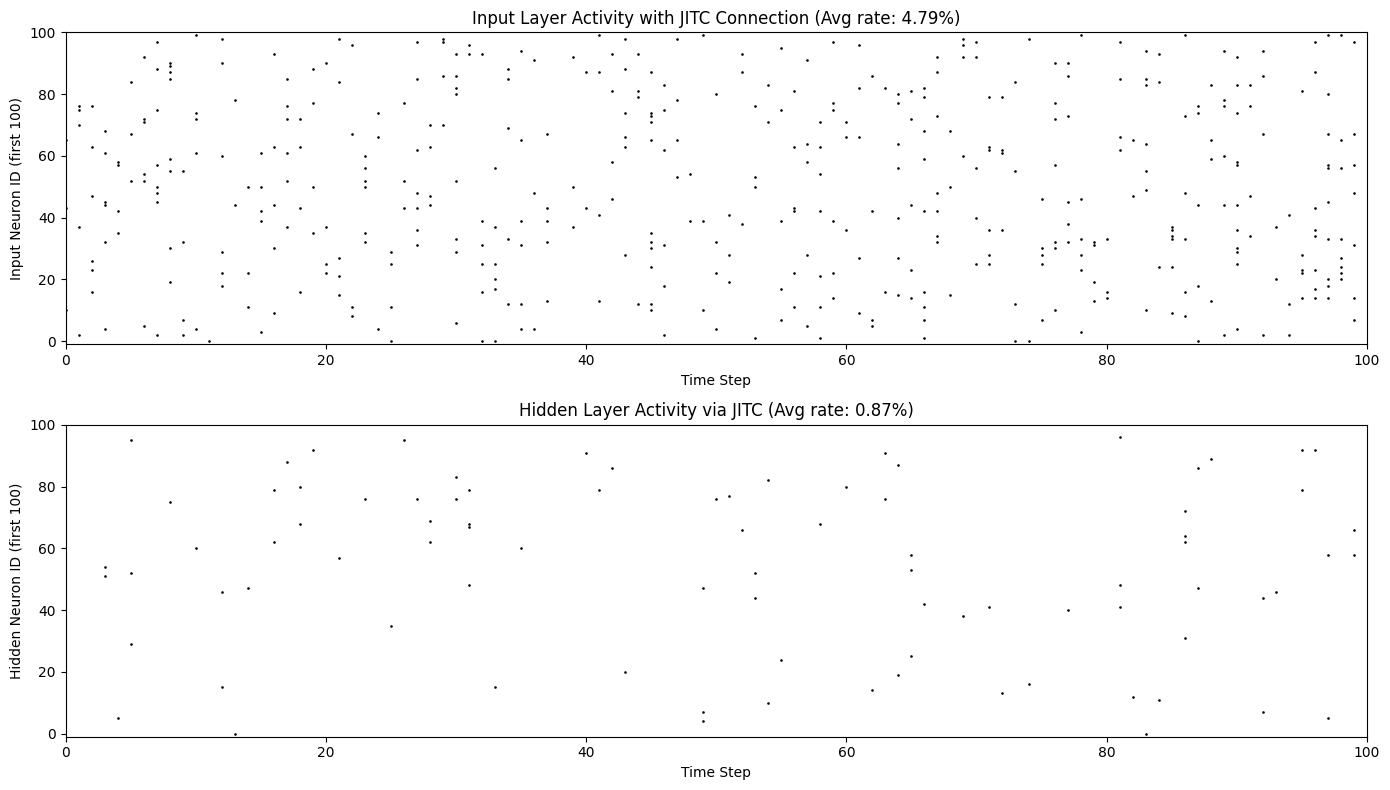


Activity statistics:
  Input layer total spikes: 479
  Hidden layer total spikes: 87
  Average input rate: 0.048
  Average hidden rate: 0.009

Note: Using JIT connections for just-in-time connection generation with extremely low memory usage!


In [13]:
# Use braintools to visualize network activity patterns
import braintools

print("Visualizing network activity over multiple time steps...\n")

# Record time series activity (use smaller network for visualization)
# Create a visualization-friendly network
viz_network = MassiveJITCNetwork(
    n_input=1000,
    n_hidden=500,
    n_output=50,
    conn_prob=0.05,
    seed=2025
)

n_timesteps = 100
spike_history_input = []
spike_history_hidden = []

brainstate.random.seed(888)
for t in range(n_timesteps):
    # Generate input spikes (higher firing rate for visualization)
    input_pattern = brainstate.random.bernoulli(0.05, size=(1000,))
    input_spikes = brainevent.BinaryArray(input_pattern)

    # Forward propagation
    output, hidden_spikes = viz_network.forward(input_spikes)

    # Record activity (first 100 neurons)
    spike_history_input.append(np.array(input_pattern[:100], dtype=int))
    spike_history_hidden.append(np.array(hidden_spikes.value[:100], dtype=int))

# Convert to matrix
spike_matrix_input = np.array(spike_history_input)  # (100, 100)
spike_matrix_hidden = np.array(spike_history_hidden)  # (100, 100)

# Use braintools.visualize.raster_plot to plot
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

ts = np.arange(n_timesteps)

# Input layer activity
ax = plt.subplot(2, 1, 1)
braintools.visualize.raster_plot(
    ts,
    spike_matrix_input,
    markersize=3,
    ax=ax,
    xlim=(0, n_timesteps),
    ylim=(-1, 100),
    xlabel='Time Step',
    ylabel='Input Neuron ID (first 100)',
    title=f'Input Layer Activity with JITC Connection (Avg rate: {spike_matrix_input.mean():.2%})',
    show=False
)

# Hidden layer activity
ax = plt.subplot(2, 1, 2)
braintools.visualize.raster_plot(
    ts,
    spike_matrix_hidden,
    markersize=3,
    ax=ax,
    xlim=(0, n_timesteps),
    ylim=(-1, 100),
    xlabel='Time Step',
    ylabel='Hidden Neuron ID (first 100)',
    title=f'Hidden Layer Activity via JITC (Avg rate: {spike_matrix_hidden.mean():.2%})',
    show=False
)

plt.tight_layout()
plt.show()

print(f"\nActivity statistics:")
print(f"  Input layer total spikes: {spike_matrix_input.sum()}")
print(f"  Hidden layer total spikes: {spike_matrix_hidden.sum()}")
print(f"  Average input rate: {spike_matrix_input.mean():.3f}")
print(f"  Average hidden rate: {spike_matrix_hidden.mean():.3f}")
print(f"\nNote: Using JIT connections for just-in-time connection generation with extremely low memory usage!")

## 7. Advanced techniques: Row-oriented vs Column-oriented

BrainEvent provides two orientations of JIT connections:
- **R (Row-oriented)**: `JITCHomoR`, `JITCNormalR`, `JITCUniformR`
- **C (Column-oriented)**: `JITCHomoC`, `JITCNormalC`, `JITCUniformC`

### When to use row-oriented (R)?
- ✅ Standard forward propagation: `spikes @ weights`
- ✅ Presynaptic spike-driven computation
- ✅ Most spiking neural network applications

### When to use column-oriented (C)?
- ✅ Backward propagation
- ✅ Postsynaptic spike-driven computation
- ✅ Specific algorithm requirements

In [15]:
# Row-oriented vs Column-oriented comparison
n = 5000
m = 3000

# Create row-oriented and column-oriented JIT connections
jitc_row = brainevent.JITCScalarR((0.1, 0.05, 100), shape=(n, m))
jitc_col = brainevent.JITCScalarC((0.1, 0.05, 100), shape=(n, m))

# Generate test input
brainstate.random.seed(0)
spikes = brainevent.BinaryArray(brainstate.random.bernoulli(0.02, size=(n,)))

print(f"Test configuration: {n} -> {m}, firing spikes: {spikes.sum()}\n")

# Warm-up
_ = jax.block_until_ready(spikes @ jitc_row)
_ = jax.block_until_ready(spikes @ jitc_col)

n_trials = 100

# Row-oriented performance
start = time.time()
for _ in range(n_trials):
    result_row = jax.block_until_ready(spikes @ jitc_row)
row_time = (time.time() - start) / n_trials

# Column-oriented performance
start = time.time()
for _ in range(n_trials):
    result_col = jax.block_until_ready(spikes @ jitc_col)
col_time = (time.time() - start) / n_trials

print("Performance comparison (matrix-vector multiplication):")
print(f"  Row-oriented (R): {row_time*1000:.3f} ms")
print(f"  Column-oriented (C): {col_time*1000:.3f} ms")
print(f"\nFor forward propagation, recommend using row-oriented (JITCScalarR, JITCNormalR, JITCUniformR)")

Test configuration: 5000 -> 3000, firing spikes: 106

Performance comparison (matrix-vector multiplication):
  Row-oriented (R): 11.377 ms
  Column-oriented (C): 11.072 ms

For forward propagation, recommend using row-oriented (JITCHomoR, JITCNormalR, JITCUniformR)


## 8. Summary

In this tutorial, we learned:

1. ✅ **JIT connection principles**: Don't store weights, dynamically generate connections
2. ✅ **JITCHomoR**: All connections have the same weight
3. ✅ **JITCNormalR**: Normal distribution weights
4. ✅ **JITCUniformR**: Uniform distribution weights
5. ✅ **Memory advantages**: Extremely low memory usage, suitable for ultra-large-scale networks
6. ✅ **Performance comparison**: Computational performance comparable to CSR
7. ✅ **Practical application**: Building million-neuron networks
8. ✅ **Orientation selection**: Row-oriented vs Column-oriented

### Key takeaways
- 🔑 **JIT connections are suitable for**: Ultra-large-scale networks, random connections, memory-constrained scenarios
- 🔑 **Memory savings**: Thousands of times or more
- 🔑 **Reproducibility**: Fixed seed ensures consistent results
- 🔑 **Recommended usage**: BinaryArray @ JITCHomoR/JITCNormalR/JITCUniformR

## Next Steps

In the next tutorial, we will learn:
- 📚 **Tutorial 4**: Fixed connection count structures - FixedPreNumConn, FixedPostNumConn
- Learn how to create networks where each neuron has a fixed number of connections
- Suitable for biologically realistic network topologies